In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader

In [4]:
data = pd.read_csv("/content/customers.csv")
data.head(30)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A
5,461319,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6,C
6,460156,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6,C
7,464347,Female,No,33,Yes,Healthcare,1.0,Low,3.0,Cat_6,D
8,465015,Female,Yes,61,Yes,Engineer,0.0,Low,3.0,Cat_7,D
9,465176,Female,Yes,55,Yes,Artist,1.0,Average,4.0,Cat_6,C


In [5]:
data.columns

Index(['ID', 'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
       'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1',
       'Segmentation'],
      dtype='object')

In [6]:
data = data.drop(columns=["ID"])

In [7]:
data.fillna({"Work_Experience": 0, "Family_Size": data["Family_Size"].median()}, inplace=True)

In [8]:
categorical_columns = ["Gender", "Ever_Married", "Graduated", "Profession", "Spending_Score", "Var_1"]
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

In [9]:
label_encoder = LabelEncoder()
data["Segmentation"] = label_encoder.fit_transform(data["Segmentation"])

In [10]:
X = data.drop(columns=["Segmentation"])
y = data["Segmentation"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [13]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [14]:
class PeopleClassifier(nn.Module):
    def __init__(self, input_size):
        super(PeopleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,8)
        self.fc4 = nn.Linear(8,4)


    def forward(self,x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x


In [15]:
model = PeopleClassifier(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [16]:
def train_model(model, train_loader,criterion,optimizer,epochs):
  for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      output = model(X_batch)
      loss = criterion(output,y_batch)
      loss.backward()
      optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

In [17]:
train_model(model, train_loader,criterion,optimizer,epochs=100)

Epoch 10/100, Loss: 1.4145
Epoch 20/100, Loss: 1.1598
Epoch 30/100, Loss: 1.0176
Epoch 40/100, Loss: 1.2596
Epoch 50/100, Loss: 1.1222
Epoch 60/100, Loss: 1.1355
Epoch 70/100, Loss: 1.2731
Epoch 80/100, Loss: 1.1475
Epoch 90/100, Loss: 0.8587
Epoch 100/100, Loss: 1.4130


In [18]:
def train_model(model, train_loader,criterion,optimizer,epochs):
  for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
      optimizer.zero_grad()
      output = model(X_batch)
      loss = criterion(output,y_batch)
      loss.backward()
      optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

train_model(model, train_loader,criterion,optimizer,epochs=100)

Epoch 10/100, Loss: 1.1647
Epoch 20/100, Loss: 1.1441
Epoch 30/100, Loss: 1.4565
Epoch 40/100, Loss: 1.3834
Epoch 50/100, Loss: 0.9658
Epoch 60/100, Loss: 1.0866
Epoch 70/100, Loss: 1.1305
Epoch 80/100, Loss: 0.8523
Epoch 90/100, Loss: 1.1094
Epoch 100/100, Loss: 1.1101


In [19]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        actuals.extend(y_batch.numpy())

In [20]:
accuracy = accuracy_score(actuals, predictions)
conf_matrix = confusion_matrix(actuals, predictions)
class_report = classification_report(actuals, predictions, target_names=[str(i) for i in label_encoder.classes_])
print("Name: HAREESH R         ")
print("Register No: 212223230068      ")
print(f'Test Accuracy: {accuracy:.2f}%')
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Name: HAREESH R         
Register No: 212223230068      
Test Accuracy: 0.46%
Confusion Matrix:
 [[204 148  87 145]
 [134 152 129  75]
 [ 64 103 245  60]
 [112  57  31 393]]
Classification Report:
               precision    recall  f1-score   support

           A       0.40      0.35      0.37       584
           B       0.33      0.31      0.32       490
           C       0.50      0.52      0.51       472
           D       0.58      0.66      0.62       593

    accuracy                           0.46      2139
   macro avg       0.45      0.46      0.46      2139
weighted avg       0.46      0.46      0.46      2139



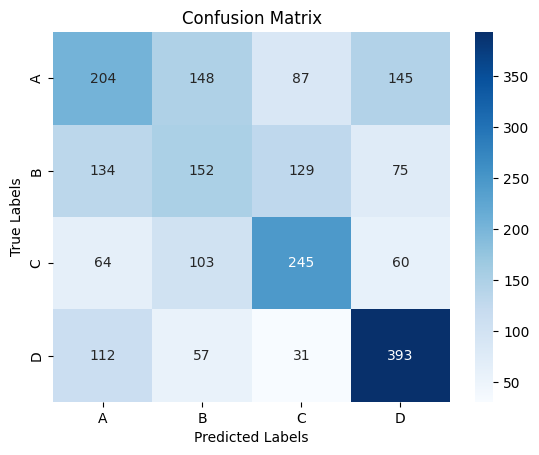

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,fmt='g')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [22]:
sample_input = X_test[12].clone().unsqueeze(0).detach().type(torch.float32)
with torch.no_grad():
    output = model(sample_input)
    # Select the prediction for the sample (first element)
    predicted_class_index = torch.argmax(output[0]).item()
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]
print("Name: HAREESH R         ")
print("Register No: 212223230068      ")
print(f'Predicted class for sample input: {predicted_class_label}')
print(f'Actual class for sample input: {label_encoder.inverse_transform([y_test[12].item()])[0]}')

Name: HAREESH R         
Register No: 212223230068      
Predicted class for sample input: D
Actual class for sample input: D
